<a href="https://colab.research.google.com/github/Vriddhi-Shri/Heat_Load_Prediction/blob/main/lstm_discrete_heating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import concat
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
# Load data
df = read_csv('/kaggle/input/discrete-heating/podstanica_vreme.csv', header=0, index_col=0)
df = df.set_index('datum')
df = df[['temp','humidity','wind_speed','wind_deg','qizm']]
df.head()

,temp,humidity,wind_speed,wind_deg,qizm
datum,,,,,
2017-02-11 00:00:00,-0.94,63,5.1,50,1.0
2017-02-11 01:00:00,-1.34,68,4.6,40,0.0
2017-02-11 02:00:00,-1.64,68,4.6,40,0.0
2017-02-11 03:00:00,-1.70,68,4.1,50,0.0
2017-02-11 04:00:00,-1.61,68,3.1,40,1.0


In [ ]:
# Check missing values
df.isnull().sum()

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)
replace_missing(df['qizm'])
# replace_missing(df['Min_T'])
# replace_missing(df['T_P'])
# replace_missing(df['UWC'])

In [ ]:
df.isnull().sum()

In [ ]:
# Define constants
n_features = 5
n_hours = 24
train_size = int(len(df) * 0.5)


# Convert data to supervised learning problem
reframed = series_to_supervised(df.values, n_hours, 1, dropnan=True)
reframed = reframed.drop(columns=['var1(t)','var2(t)','var3(t)','var4(t)'])

# Scale the data to the range of 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed.values.astype('float32'))

# Split the data into train and test sets
n_obs = scaled.shape[1]
train = scaled[:train_size, :]
test = scaled[train_size:, :]

In [ ]:
train.shape

(5916, 121)

In [ ]:
train_X, train_y = train[:, :n_obs-1], train[:, n_obs-1]
test_X, test_y = test[:, :n_obs-1], test[:, n_obs-1]


# Reshape the input data into the desired shape for the LSTM model
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

In [ ]:
train_y

array([0.        , 0.01669759, 0.0296846 , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [ ]:
# design network
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/100
83/83 [==============================] - 17s 129ms/step - loss: 0.1284 - val_loss: 0.1446
Epoch 2/100
83/83 [==============================] - 10s 115ms/step - loss: 0.1222 - val_loss: 0.1427
Epoch 3/100
83/83 [==============================] - 9s 112ms/step - loss: 0.1146 - val_loss: 0.1320
Epoch 4/100
83/83 [==============================] - 9s 114ms/step - loss: 0.1031 - val_loss: 0.1305
Epoch 5/100
83/83 [==============================] - 11s 127ms/step - loss: 0.0957 - val_loss: 0.1143
Epoch 6/100
83/83 [==============================] - 9s 113ms/step - loss: 0.0831 - val_loss: 0.1104
Epoch 7/100
83/83 [==============================] - 9s 111ms/step - loss: 0.0818 - val_loss: 0.1149
Epoch 8/100
83/83 [==============================] - 10s 121ms/step - loss: 0.0700 - val_loss: 0.0836
Epoch 9/100
83/83 [==============================] - 10s 115ms/step - loss: 0.0633 - val_loss: 0.0791
Epoch 10/100
83/83 [==============================] - 10s 115ms/step - loss: 0.0607 - 

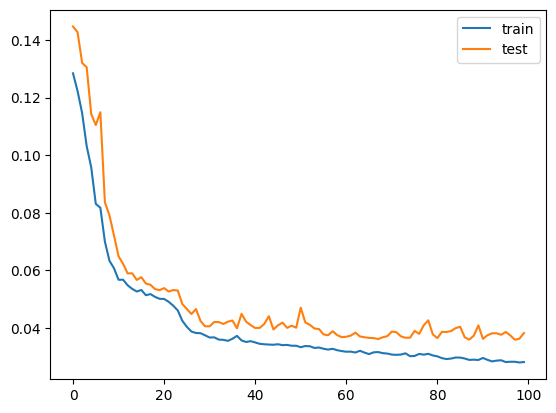

In [ ]:
import matplotlib.pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

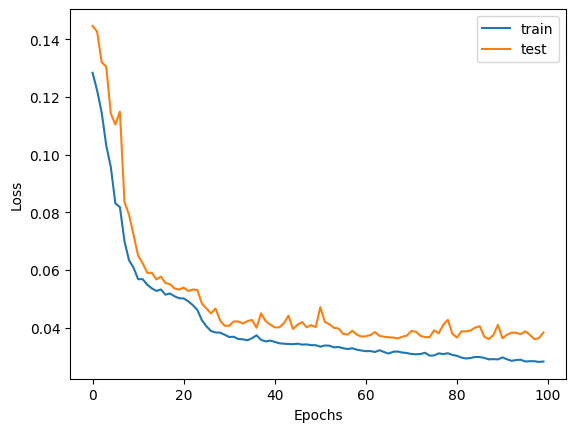

In [ ]:
import matplotlib.pyplot as plt
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
yhat = model.predict(test_X)

128/128 [==============================] - 1s 8ms/step


In [ ]:
tttest_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [ ]:
# invert scaling for forecast
from numpy import concatenate
inv_yhat = concatenate((tttest_X, yhat), axis=1)

In [ ]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [ ]:
# invert scaling for actual
ttest_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((tttest_X, ttest_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [ ]:
inv_yhat = inv_yhat[:,n_hours*n_features]
inv_y = inv_y[:,n_hours*n_features]

In [ ]:
# y_pred = model.predict(X_test)
from sklearn.metrics import r2_score
r2 = r2_score(inv_y, inv_yhat)
print("R-squared value:", r2)

R-squared value: 0.74264917377865


In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.651


<function matplotlib.pyplot.show(close=None, block=None)>

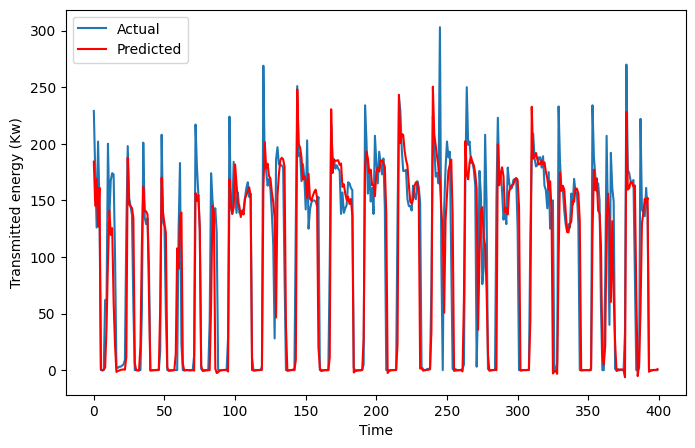

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(inv_y[800:1200])
plt.plot(inv_yhat[800:1200], color='red')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.ylabel('Transmitted energy (Kw)')
plt.xlabel('Time')
plt.show

In [ ]:
!pip install lime

In [ ]:
import lime.lime_tabular

In [ ]:
explainer = lime.lime_tabular.RecurrentTabularExplainer(train_X,
                                                   feature_names=['Temp','Humidity','Wind speed','Wind deg','Q'],
                                                   discretize_continuous=True,
                                                   discretizer='decile',
                                                   verbose=True,
                                                   mode='regression')

In [ ]:
exp = explainer.explain_instance(test_X[1314], model.predict, num_features=10)

In [ ]:
exp.show_in_notebook()